In [26]:
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy # type: ignore
from keras import optimizers
import utils # all datareading and preprocessing functionality

In [2]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract'
label_selection = 'label' # can be 'label' or 'text_label'

In [3]:
df = utils.read_abstract_data(negatives_path=file2, positives_path=file1)
#utils.preprocess_text(data) # can be skipped here?

df.head()

,pmid,title,abstract,label,text_label
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0,control
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0,control
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0,control
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0,control
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0,control


In [45]:
df.text_label.value_counts()

text_label
pesticide    4692
control      4418
Name: count, dtype: int64

In [4]:
# number of classes
K = df[label_selection].max() + 1
K

2

In [5]:
df_train, df_test = train_test_split(df[[data_selection, 'label', 'text_label']], test_size=0.3)
df_train.head()

,abstract,label,text_label
2001,BACKGROUND AND PURPOSE: Up-regulation of thior...,0,control
7710,Anopheles epiroticus is a malaria vector in Th...,1,pesticide
7108,OBJECTIVES: Agricultural use of neonicotinoid ...,1,pesticide
6407,One approach in toxicity testing using microal...,1,pesticide
6204,We found previously that organophosphorus pest...,1,pesticide


In [6]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2500
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE) # tokenizer from tensorflow.keras.preprocessing.text
tokenizer.fit_on_texts(df_train[data_selection])
sequences_train = tokenizer.texts_to_sequences(df_train[data_selection]) # returns a simple python list of lists (of numbers)
sequences_test = tokenizer.texts_to_sequences(df_test[data_selection])

In [7]:
#df_train.shape
#[len(x) for x in sequences_train[:5]] 
len(sequences_train)

6377

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 51394 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (6377, 1884)


In [10]:
#data_train.shape
data_train[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

In [10]:
# also pad the test sequences. Note that we use the same T as for the training data
# (this is important!)
data_test = pad_sequences(sequences_test, maxlen=T)

print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (2733, 1884)


In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 50

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)                    # feel free to test different architectures!
# x = Conv1D(64, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [ ]:
optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) # these are the default values

# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer=optm,
  metrics=['accuracy']
)

In [ ]:
print('Training model...')
r = model.fit(
  data_train,
  df_train['label'],
  epochs=50,
  validation_data=(data_test, df_test['label'])
)

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [ ]:
# The outputs are not probabilities but logits;
# therefore, this check for bigger than zero (=positive class)
# mutltiply by one to get numbers instead of booleans
#P_train = ((model.predict(data_train) > 0) * 1.0).flatten()
P_train = (model.predict(data_train) > 0) * 1.0
P_train = P_train[:, 1] # only positive class

#P_test = ((model.predict(data_test > 0) * 1.0).flatten())
P_test = (model.predict(data_test) > 0) * 1.0
P_test = P_test[:, 1] # only positive


In [ ]:
cm_train = confusion_matrix(df_train['label'], P_train, normalize='true')
cm_train

In [ ]:
utils.plot_confusion_matrix(cm_train, ['set1', 'set2'])

In [ ]:
P_test

In [ ]:
cm_test = confusion_matrix(df_test['label'], P_test, normalize='true')
cm_test

In [ ]:
utils.plot_confusion_matrix(cm_test, ['set1', 'set2'])

In [11]:
def evaluate(model):
    # The outputs are not probabilities but logits;
    # therefore, this check for bigger than zero (=positive class)
    # mutltiply by one to get numbers instead of booleans
    #P_train = ((model.predict(data_train) > 0) * 1.0).flatten()
    P_train = (model.predict(data_train) > 0) * 1.0
    P_train = P_train[:, 1] # only positive class

    #P_test = ((model.predict(data_test > 0) * 1.0).flatten())
    P_test = (model.predict(data_test) > 0) * 1.0
    P_test = P_test[:, 1] # only positive
    cm_test = confusion_matrix(df_test['label'], P_test, normalize='true')
    print(cm_test)
    utils.plot_confusion_matrix(cm_test, ['control', 'pesticide'])

In [ ]:
D = 50
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(16, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) # these are the default values
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer=optm,
  metrics=['accuracy']
)

r = model.fit(
  data_train,
  df_train['label'],
  epochs=15,
  validation_data=(data_test, df_test['label'])
)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6724 - loss: 0.6037 - val_accuracy: 0.9440 - val_loss: 0.1557
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9708 - loss: 0.0847 - val_accuracy: 0.9715 - val_loss: 0.0760
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9931 - loss: 0.0272 - val_accuracy: 0.9766 - val_loss: 0.0752
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9980 - loss: 0.0107 - val_accuracy: 0.9685 - val_loss: 0.0909
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9718 - val_loss: 0.0923
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 0.9733 - val_loss: 0.0972
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9992 - loss: 0.0051 - val_accuracy: 0.9715 - val_loss: 0.0970
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accu

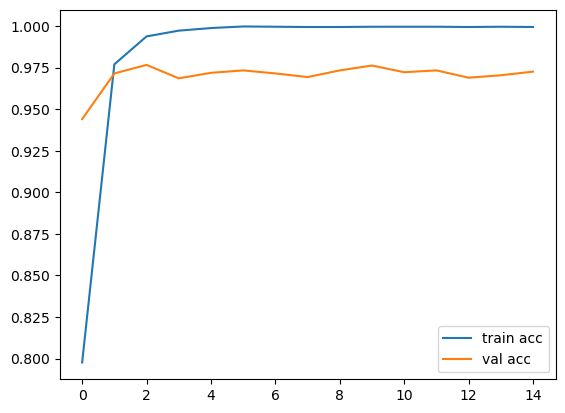

In [23]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[0.97251908 0.02748092]
 [0.02037948 0.97962052]]


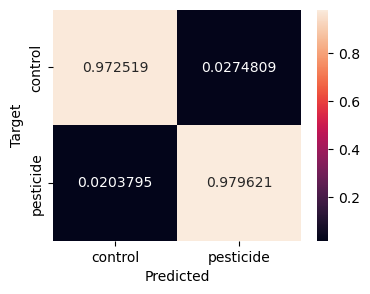

In [24]:
#Test utils.evaluate_model()
evaluate(model)

## Evaluate on completely unseen data

In [31]:
# check the new file
curated_pesticide_abstracts = pd.read_csv('./data/curated_pesticides_abstracts.txt', sep='\t')
curated_pesticide_abstracts['label'] = 1
#remove rows with NaN in abstract column
curated_pesticide_abstracts = curated_pesticide_abstracts.dropna(subset=['abstract'])
print(curated_pesticide_abstracts.shape)
curated_pesticide_abstracts.head(10)


(151, 4)


,pmid,title,abstract,label
0,10234476,Pesticide induced changes of nitric oxide synt...,Organic insecticides are well known neurotoxic...,1
1,10369463,Minor structural changes in nicotinoid insecti...,The major nitroimine insecticide imidacloprid ...,1
2,10583056,Evidence for double resistance to permethrin a...,A rising prevalence of head lice among school ...,1
3,15496540,Pesticides and lung cancer risk in the agricul...,The authors examined the relation between 50 w...,1
4,16452832,Pendimethalin exposure and cancer incidence am...,"Pendimethalin, a widely used herbicide, has be...",1
5,16704049,Dose-additive inhibition of chinook salmon ace...,Organophosphate and carbamate insecticides are...,1
6,19248625,[The effect of pesticide acetamiprid on bioche...,The effects of ecological real concentration o...,1
7,19934164,"Time-course, dose-response, and age comparativ...",N-Methyl carbamate insecticides are reversible...,1
8,22361216,Effect of chronic exposure to pendimethalin on...,"In this study, the in vivo effects of chronic ...",1
9,22393406,Nicotine-like effects of the neonicotinoid ins...,Acetamiprid (ACE) and imidacloprid (IMI) belon...,1


In [ ]:
sequences_val_pos = tokenizer.texts_to_sequences(curated_pesticide_abstracts[data_selection])
data_val_pos = pad_sequences(sequences_val_pos, maxlen=T)

In [34]:
# re-create the model to be sure there is no mix-up
D = 50
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) # these are the default values
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer=optm,
  metrics=['accuracy']
)

r = model.fit(
  data_train,
  df_train['label'],
  epochs=15,
  validation_data=(data_test, df_test['label'])
)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7138 - loss: 0.5781 - val_accuracy: 0.9378 - val_loss: 0.1900
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9635 - loss: 0.1154 - val_accuracy: 0.9777 - val_loss: 0.0704
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9907 - loss: 0.0368 - val_accuracy: 0.9817 - val_loss: 0.0576
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9955 - loss: 0.0196 - val_accuracy: 0.9806 - val_loss: 0.0565
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9978 - loss: 0.0105 - val_accuracy: 0.9802 - val_loss: 0.0621
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9979 - loss: 0.0089 - val_accuracy: 0.9817 - val_loss: 0.0627
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9995 - loss: 0.0041 - val_accuracy: 0.9821 - val_loss: 0.0635
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9992 - loss: 0.0042 - val_accu

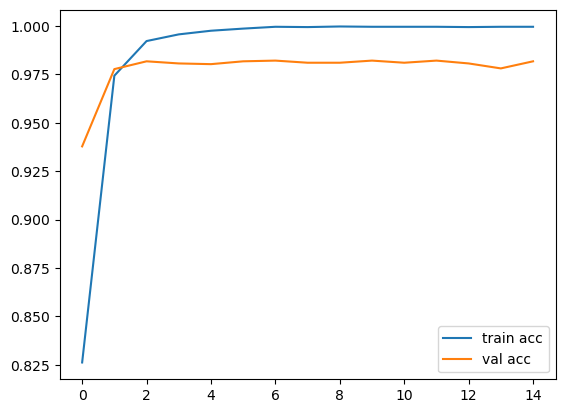

In [35]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[0.         0.        ]
 [0.05298013 0.94701987]]


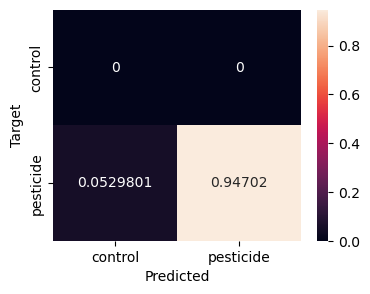

In [ ]:
P_val_pos = (model.predict(data_val_pos) > 0) * 1.0
P_val_pos = P_val_pos[:, 1] # only positive
cm_val_pos = confusion_matrix(curated_pesticide_abstracts['label'], P_val_pos, normalize='true')
print(cm_val_pos)
utils.plot_confusion_matrix(cm_val_pos, ['control', 'pesticide'])

### An (almost) completely negative set

In [40]:
set1 = pd.read_csv('./data/abstracts_2025_04_09.csv', sep='\t')
print(set1.shape)

set2 = pd.read_csv('./data/abstracts_2025_04_15.csv', sep='\t')
print(set2.shape)

# concat set 1 and set 2
baseline_abstracts = pd.concat([set1, set2], axis=0)
baseline_abstracts = baseline_abstracts.drop_duplicates(subset=['pmid'], keep='first')
baseline_abstracts.dropna(subset=['abstract'], inplace=True)
# reset index
baseline_abstracts.reset_index(drop=True, inplace=True)

print(baseline_abstracts.shape)

baseline_abstracts['label'] = 0

baseline_abstracts

(2907, 3)
(2375, 3)
(4708, 3)


,pmid,title,abstract,label
0,40205634,A Python package for fast GPU-based proton pen...,Open-source GPU-based Monte Carlo (MC) proton ...,0
1,40205627,Efficacy and Safety of Direct Oral Anti-Coagul...,"Direct oral anticoagulants (DOAC), including d...",0
2,40205626,Design and validation of a novel dosimetry pha...,We present a novel phantom design for conducti...,0
3,40205625,Associations of neighbourhood walkability with...,Neighbourhood walkability is known to be posit...,0
4,40205624,Psychometric evaluation of the problem areas i...,to assesses the psychometric properties of the...,0
...,...,...,...,...
4703,39198200,Enhanced functionality and migration of human ...,The maintenance of peri-implant health relies ...,0
4704,39198199,Effect of build orientation on the wear resist...,This in vitro study investigated the effect of...,0
4705,39034113,Effect of wall thickness on shape accuracy of ...,This study aimed to analyze how the wall thick...,0
4706,38925985,Dental human enamel wear caused by ceramic ant...,Fixed restorations and dental enamel have diff...,0


In [42]:
sequences_val_negative = tokenizer.texts_to_sequences(baseline_abstracts[data_selection])
data_val_neg = pad_sequences(sequences_val_negative, maxlen=T)

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[0.71983857 0.28016143]
 [0.         0.        ]]


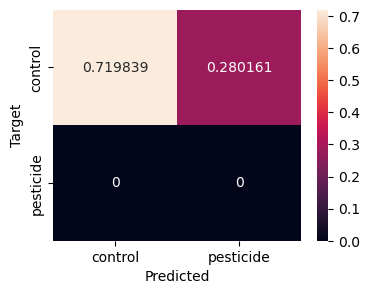

In [44]:
P_val_neg = (model.predict(data_val_neg) > 0) * 1.0
P_val_neg = P_val_neg[:, 1] # only positive
cm_val_neg = confusion_matrix(baseline_abstracts['label'], P_val_neg, normalize='true')
print(cm_val_neg)
utils.plot_confusion_matrix(cm_val_neg, ['control', 'pesticide'])